In [6]:
from orphics import sehgal, maps
import healpy as hp
from pixell import utils, enmap, curvedsky, enplot, wcsutils, powspec
import os
import numpy as np

import matplotlib.pyplot as plt
import lmdb
from cosmikyu import datasets, transforms, gan, model
from cosmikyu import nn as cnn
import torch
from orphics import maps as omaps

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
shape, wcs = enmap.fullsky_geometry(res=0.5*utils.arcmin)
stamp_shape = (128,128)
ycent = shape[0] // 2
ydelta = int(10*utils.degree/(0.5*utils.arcmin))
xdelta = ydelta
ymin, ymax = ycent-ydelta, ycent+ydelta
print(shape, ycent, ydelta, ymin, ymax)

template = enmap.zeros(shape[:], wcs)
template = template[ymin:ymax,:].copy()
nshape, nwcs = template.shape, template.wcs
ntiles = np.array(nshape)//128
print(nshape)


lmax = 10000
ps_scalar = powspec.read_camb_scalar("/home/dwhan89/scratch/data/sehgal_et_al_sims/theoryCls/bode_almost_wmap5_lmax_1e4_scalCls.dat")
clpp = ps_scalar[1][0][0][:lmax+1]
L = np.arange(lmax+1)
clkk = clpp*(L*(L+1))**2/4

beam_fwhm = 0.9
beam_fwhm = np.deg2rad(beam_fwhm/60.)
sigma     = beam_fwhm/(2.*np.sqrt(2.*np.log(2)))
def get_f_ell(l):
    f_ell = np.exp(-(l)**2.*sigma**2./2)
    return l, f_ell

alm = curvedsky.rand_alm(clkk)
alm = hp.almxfl(alm, get_f_ell(L)[1])
kmap = curvedsky.alm2map(alm, template)
kmap = kmap[np.newaxis,...]

norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/201020_logzshrink_normalization_info_validation.npz"
SDN = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file, channel_idxes=["kappa"])
SUN = transforms.SehgalDataUnnormalizerScaledLogZShrink(norm_info_file)



cuda=False
ngpu = 4
ngpu = 0 if not cuda else ngpu
if torch.cuda.is_available() and not cuda:
    print("[WARNING] You have a CUDA device. You probably want to run with CUDA enabled")
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
device = torch.device("cuda" if cuda else "cpu")
STanh = cnn.ScaledTanh(30., 2./30.)
nconv_fc = 64


kernal_size = 4
stride = 2
padding = 1
output_padding = 0
dropout_rate = 0
nbatch = 32


LF = cnn.LinearFeature(4,4)
dropout_rate=0
nconv_layer_gen=4
nthresh_layer_gen = 3
experiment_id = "491906adeb814393bc88e901396088ee"
model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_pixganwgp_301020/{}/model".format(experiment_id)
save_point = 2
pixgan_generator = model.UNET_Generator((5,)+shape, nconv_layer=nconv_layer_gen, nconv_fc=nconv_fc, ngpu=ngpu,
        kernal_size=kernal_size, stride=stride, padding=padding, output_padding=output_padding, normalize=True, 
        activation=[LF,STanh], nin_channel=1, nout_channel=4,
         nthresh_layer=nthresh_layer_gen, dropout_rate=dropout_rate).to(device=device)
generator_state_file = os.path.join(model_dir, "generator{}.pt".format("_{}".format(save_point)))
pixgan_generator.load_state_dict(torch.load(generator_state_file, map_location=device))

LF = cnn.LinearFeature(5,5, bias=True)
nconv_layer_gen=4
nthresh_layer_gen = 0
save_point = 0
experiment_id = "6b813aa2f30148f1b8bd3ca4cd88c788"
model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_forse_081020/{}/model".format(experiment_id)
forse_generator = model.FORSE_Generator((5,)+shape, nconv_layer=nconv_layer_gen, nconv_fc=nconv_fc, ngpu=ngpu,
        kernal_size=kernal_size, stride=stride, padding=padding, output_padding=output_padding, normalize=True,
        activation=[LF,STanh], nin_channel=5, nout_channel=5,
        nthresh_layer=nthresh_layer_gen, dropout_rate=dropout_rate).to(device=device)

generator_state_file = os.path.join(model_dir, "generator{}.pt".format("_{}".format(save_point)))
forse_generator.load_state_dict(torch.load(generator_state_file, map_location=device))

pixgan_generator.eval()
forse_generator.eval()

pass
    
    


(21601, 43200) 10800 1200 9600 12000
(2400, 43200)
[WARNING] You have a CUDA device. You probably want to run with CUDA enabled


In [8]:
class Batch(object):
    # "https://stackoverflow.com/questions/16873441/form-a-big-2d-array-from-multiple-smaller-2d-arrays/16873755#16873755"
    def __init__(self, block_shape):
        self.bshape = block_shape

    def __call__(self, sample):
        if sample.ndim == 2:
            sample = sample[np.newaxis,np.newaxis,...]
        elif sample.ndim == 3: 
            sample = sample[:,np.newaxis,...] 
        else:
            assert(False)
        
        nch = sample.shape[0]
        assert(nch == self.bshape[0])
        h, w = sample.shape[-2], sample.shape[-1]
        nrows, ncols = self.bshape[-2], self.bshape[-1]
        return (sample.reshape(nch, h // nrows, nrows, -1, ncols)
                .swapaxes(2, 3)
                .reshape(nch, -1, nrows, ncols).swapaxes(0, 1))
    
class UnBatch(object):
        # "https://stackoverflow.com/questions/16873441/form-a-big-2d-array-from-multiple-smaller-2d-arrays/16873755#16873755"
    def __init__(self, block_shape):
        self.bshape = block_shape

    def __call__(self, sample):
        assert(sample.ndim ==4)
        nbatch, nch = sample.shape[:2]
        nrows, ncols = sample.shape[2:]
        sample = sample.swapaxes(0,1)
        h, w = self.bshape[-2], self.bshape[-1]
        return (sample.reshape(nch,h // nrows, -1, nrows, ncols)
                .swapaxes(2, 3)
                .reshape(nch,1, h, w).swapaxes(0, 1))
        
        


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.5864521416318542 0.6999697216170001


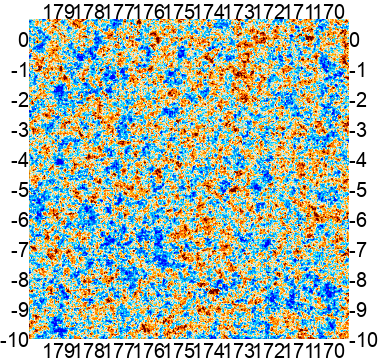

44.41602400728087 31.956691235652592


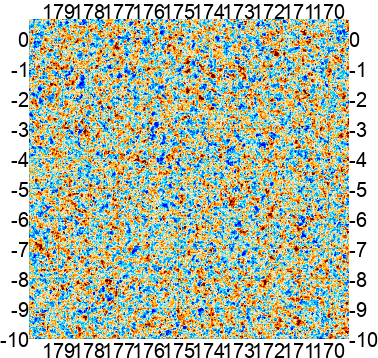

146.01520951107693 91.18645253900098


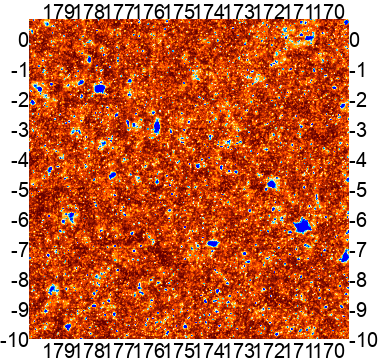

292.0247149158789 301.5624734209912


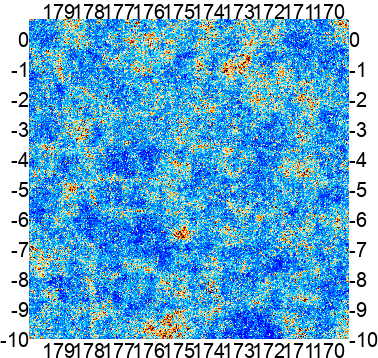

608.4260828387817 244.8274403550808


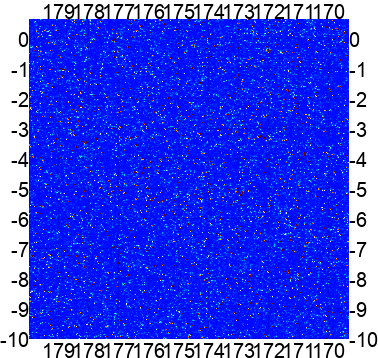

In [13]:
nbatch = 128
def generate_samples(input_imgs, ret_resd=False, transforms=[SUN], nbatch=nbatch, shape=shape, wrap=True, edge_blend=True):
    if input_imgs.ndim == 2: 
        input_imgs = input_imgs[np.newaxis,...]
    nch, Ny, Nx = input_imgs.shape
    ny, nx = shape[-2:]
    padded_shape = (np.ceil([Ny/ny, Nx/nx])*np.array([ny,nx])).astype(np.int)
    Ny_pad, Nx_pad = padded_shape[0], padded_shape[1]
    #Ntiles = int(np.product(np.ceil([Ny/ny, Nx/nx])))
    remain = [Ny%ny, Nx%nx]
    if wrap:
        input_imgs = np.pad(input_imgs,((0,0),(0,Ny_pad-Nx),(0,Nx_pad-Nx)),mode="wrap") 
    B = Batch((nch,ny,nx))
    def process_ml(input_imgs, ret_resd):
        input_imgs = B(input_imgs)
        Nstamp = input_imgs.shape[0]
        output_imgs = np.zeros((Nstamp, 5, ny,nx))
        if ret_resd:
            resd = output_imgs.copy()
        for batch in np.array_split(np.arange(input_imgs.shape[0]), nbatch):
            input_tensor = torch.autograd.Variable(Tensor(input_imgs[batch].copy())) 
            ret = pixgan_generator(input_tensor).detach()
            ret = torch.cat((input_tensor, ret), 1)
            #ret = torch.cat((input_tensor[batch,...], ret), 1)
            if ret_resd: resd[batch] = ret.data.to(device="cpu").numpy()
            ret = forse_generator(ret).detach()
            output_imgs[batch] = ret.data.to(device="cpu").numpy()
        return (output_imgs, None) if not ret_resd else (output_imgs, resd)

    UB = UnBatch((nch,Ny_pad,Nx_pad))
    def post_process(output_imgs, resd, ret_resd=ret_resd, UB=UB):
        output_imgs = UB(output_imgs)
        output_imgs = output_imgs[0,...,:Ny,:Nx]
        if ret_resd:
            resd = UB(resd)
            resd = resd[0,...,:Ny,:Nx]
            resd = output_imgs-resd
        return output_imgs, resd
    
    output_imgs, resd = process_ml(input_imgs, ret_resd)
    output_imgs, resd = post_process(output_imgs, resd)
    if edge_blend:
        ## inner part
        taper_width = 20
        
        def get_taper(input_imgs,ywidth,xwidth):
            taper = B(input_imgs*0)
            taper_stamp = omaps.cosine_window(ny,nx,ywidth,xwidth)
            minval = np.min(taper_stamp[taper_stamp!=0])
            taper_stamp[taper_stamp==0] = minval
            taper[...,:,:] = taper_stamp
            taper = UB(taper)[0]
            return taper
        
        def get_taper_imgs(input_imgs, shifts):
            y_shift, x_shift = shifts
            if y_shift > 0:
                taper_imgs = input_imgs[..., y_shift:-1*y_shift,:].copy()
                UB = UnBatch((nch,Ny_pad-2*y_shift,Nx_pad))
            else:
                taper_imgs = input_imgs[..., :,x_shift:-1*x_shift].copy()
                UB = UnBatch((nch,Ny_pad,Nx_pad-2*x_shift))
            taper_imgs, _ = process_ml(taper_imgs, True)
            taper_imgs, _ = post_process(taper_imgs, None, ret_resd=False,UB=UB)
            return taper_imgs
        
        taper = get_taper(input_imgs, taper_width, 0)
        output_imgs[...,64:-64, :] = (output_imgs*taper)[...,64:-64, :]
        output_imgs[...,64:-64, :] += (get_taper_imgs(input_imgs, [64,0])*(1-taper[...,64:-64,:]))
        taper = get_taper(input_imgs,  0, taper_width)
        output_imgs[...,:,64:-64] = (output_imgs*taper)[...,:,64:-64]
        output_imgs[...,:,64:-64] += (get_taper_imgs(input_imgs, [0,64])*(1-taper[...,:,64:-64]))     
    
    for transf in transforms:
        output_imgs = transf(output_imgs.copy())
        if ret_resd:
            resd = transf(resd.copy())
    
    return output_imgs if not ret_resd else (output_imgs, resd)
    


stamp = kmap[...,:128*10,:128*10]
stamp_wcs = stamp.wcs

idxes= np.arange(43000,43000+500)

sample = generate_samples(SDN(stamp.copy()), ret_resd=True, shape=(5,128,128), edge_blend=True)

for i in range(5):
    print(np.max(np.abs(sample[0][i]-np.abs(sample[1][i]))), np.max(np.abs(sample[1][i])))
    #enplot.pshow(enmap.enmap(sample[0][i]-sample[1][i], stamp_wcs))
    #enplot.pshow(enmap.enmap(sample[1][i], stamp_wcs))
    enplot.pshow(enmap.enmap(sample[0][i], stamp_wcs), downgrade=4)



In [12]:
'''
        def get_taper()
            taper_stamp = omaps.cosine_window(ny,nx,taper_width,taper_width)
            minval = np.min(taper_stamp[taper_stamp!=0])
            taper_stamp[taper_stamp==0] = minval
            taper[...,:,:] = taper_stamp
            taper = UB(taper)[0]
            temp = maps.cosine_window(taper.shape[-2],taper.shape[-1],taper_width,taper_width)
            temp[temp == 0] = minval
            taper = taper/temp
            del temp, taper_stamp
            
            nbatch = 128
def generate_samples(input_imgs, ret_resd=False, transforms=[SUN], nbatch=nbatch, shape=shape):
    if input_imgs.ndim == 3: input_imgs = input_imgs[np.newaxis,...]
    Nx, Ny = input_imgs.shape[-2:]
    nx, ny = shape[-2:]
    Ntiles = np.ceil([Nx/nx, Ny/ny]).astype(np.int)
    Resd = [Nx%nx, Ny%ny]
    input_imgs = torch.autograd.Variable(Tensor(input_imgs))
    
    
    ret = pixgan_generator(input_imgs).detach()
    input_imgs = torch.cat((input_imgs, ret), 1)
    ret = forse_generator(input_imgs).detach()
    ret = ret.data.to(device="cpu").numpy()
    if ret_resd:
        resd = ret-input_imgs.data.to(device="cpu").numpy()
        
    ret = ret[0]
    resd = resd[0]
    for transf in transforms:
        ret = transf(ret)
        if ret_resd:
            resd = transf(resd)
    
    return ret if not ret_resd else (ret, resd)

stamp_wcs = kmap[:1,:128*10,:128*10].wcs
sample = generate_samples(SDN(kmap[...,:128*10,:128*10].copy()), ret_resd=True)




for i in range(5):
    print(np.max(np.abs(sample[0][i]-np.abs(sample[1][i]))), np.max(np.abs(sample[1][i])))
    enplot.pshow(enmap.enmap(sample[0][i]-sample[1][i], stamp_wcs))
    enplot.pshow(enmap.enmap(sample[1][i], stamp_wcs))
    enplot.pshow(enmap.enmap(sample[0][i], stamp_wcs))
'''

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'\n        def get_taper()\n            taper_stamp = omaps.cosine_window(ny,nx,taper_width,taper_width)\n            minval = np.min(taper_stamp[taper_stamp!=0])\n            taper_stamp[taper_stamp==0] = minval\n            taper[...,:,:] = taper_stamp\n            taper = UB(taper)[0]\n            temp = maps.cosine_window(taper.shape[-2],taper.shape[-1],taper_width,taper_width)\n            temp[temp == 0] = minval\n            taper = taper/temp\n            del temp, taper_stamp\n            \n            nbatch = 128\ndef generate_samples(input_imgs, ret_resd=False, transforms=[SUN], nbatch=nbatch, shape=shape):\n    if input_imgs.ndim == 3: input_imgs = input_imgs[np.newaxis,...]\n    Nx, Ny = input_imgs.shape[-2:]\n    nx, ny = shape[-2:]\n    Ntiles = np.ceil([Nx/nx, Ny/ny]).astype(np.int)\n    Resd = [Nx%nx, Ny%ny]\n    input_imgs = torch.autograd.Variable(Tensor(input_imgs))\n    \n    \n    ret = pixgan_generator(input_imgs).detach()\n    input_imgs = torch.cat((input_imgs